<a href="https://colab.research.google.com/github/hetanshipatel/real-time-stock-price-prediction/blob/main/notebooks/01_stock_price_prediction_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
STOCK_TICKER = input("Enter stock ticker (e.g., AAPL, TSLA): ").upper()
START_DATE = input("Enter start date: ")

Enter stock ticker (e.g., AAPL, TSLA): CVX
Enter start date: 2006-01-01


In [3]:
stock_df = yf.Ticker(STOCK_TICKER).history(start=START_DATE)

if stock_df.empty:
    raise ValueError("Invalid ticker or no data found")

stock_df.reset_index(inplace=True)
stock_df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-01-03 00:00:00-05:00,26.564186,27.422591,26.476026,27.413313,13296000,0.0,0.0
1,2006-01-04 00:00:00-05:00,27.413316,27.413316,27.111713,27.334435,8838700,0.0,0.0
2,2006-01-05 00:00:00-05:00,27.227727,27.357647,26.842603,27.000364,8634800,0.0,0.0
3,2006-01-06 00:00:00-05:00,27.353004,27.640686,27.185962,27.492205,9609000,0.0,0.0
4,2006-01-09 00:00:00-05:00,27.603567,27.645327,27.167402,27.353004,6442300,0.0,0.0


In [4]:
external_tickers = {
    "SP500": "^GSPC",
    "NASDAQ": "^IXIC",
    "VIX": "^VIX",
    "US10Y": "^TNX"
}

external_dfs = []

for name, ticker in external_tickers.items():
    df_ext = yf.Ticker(ticker).history(start=START_DATE)[["Close"]]
    df_ext = df_ext.rename(columns={"Close": name})
    df_ext.reset_index(inplace=True)
    external_dfs.append(df_ext)


In [5]:
df = stock_df.copy()

for ext_df in external_dfs:
    df = pd.merge(df, ext_df, on="Date", how="left")

df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SP500,NASDAQ,VIX,US10Y
0,2006-01-03 00:00:00-05:00,26.564186,27.422591,26.476026,27.413313,13296000,0.0,0.0,1268.800049,2243.739990,11.14,NaN
1,2006-01-04 00:00:00-05:00,27.413316,27.413316,27.111713,27.334435,8838700,0.0,0.0,1273.459961,2263.459961,11.37,NaN
2,2006-01-05 00:00:00-05:00,27.227727,27.357647,26.842603,27.000364,8634800,0.0,0.0,1273.479980,2276.870117,11.31,NaN
3,2006-01-06 00:00:00-05:00,27.353004,27.640686,27.185962,27.492205,9609000,0.0,0.0,1285.449951,2305.620117,11.00,NaN
4,2006-01-09 00:00:00-05:00,27.603567,27.645327,27.167402,27.353004,6442300,0.0,0.0,1290.150024,2318.689941,11.13,NaN


In [6]:
today = datetime.today().strftime("%Y-%m-%d")
file_name = f"{STOCK_TICKER}_raw_data_{today}.csv"
df.to_csv(file_name, index=False)
file_name

'CVX_raw_data_2026-01-20.csv'

In [7]:
from google.colab import files
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

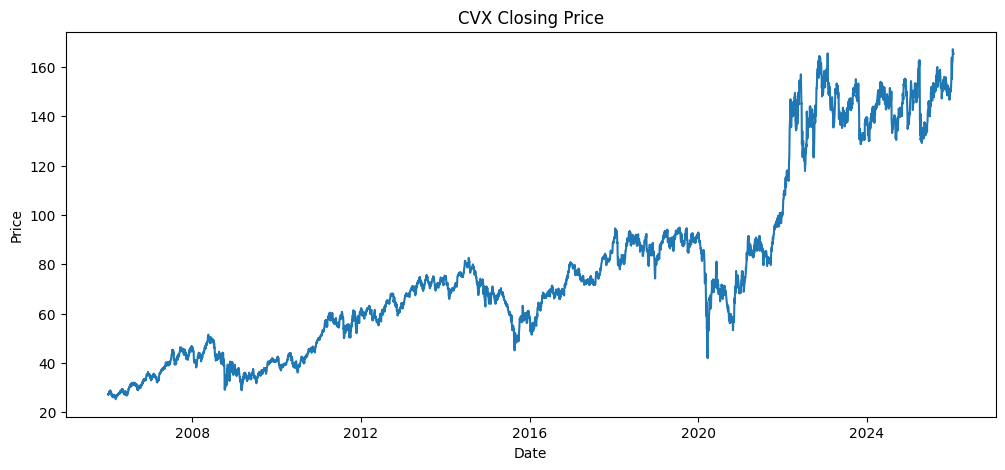

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"])
plt.title(f"{STOCK_TICKER} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

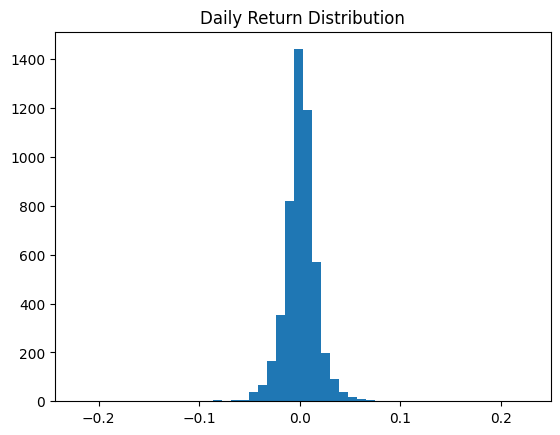

In [9]:
df["Daily_Return"] = df["Close"].pct_change()

plt.hist(df["Daily_Return"].dropna(), bins=50)
plt.title("Daily Return Distribution")
plt.show()

**Observation**

In [10]:
df['return'] = df['Close'].pct_change()

df['ma_5'] = df['Close'].rolling(5).mean()
df['ma_20'] = df['Close'].rolling(20).mean()
df['ma_50'] = df['Close'].rolling(50).mean()

df['volatility_20'] = df['return'].rolling(20).std()


In [11]:
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))


In [12]:
df['volume_ma_20'] = df['Volume'].rolling(20).mean()
df['volume_change'] = df['Volume'].pct_change()

In [13]:
import yfinance as yf

sp500 = yf.download("^GSPC", start=df.index.min(), end=df.index.max())
df['sp500_return'] = sp500['Close'].pct_change()

/tmp/ipython-input-1712149416.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=df.index.min(), end=df.index.max())
[*********************100%***********************]  1 of 1 completed


In [14]:
df.dropna(inplace=True)

In [15]:
df['target'] = df['Close'].shift(-1)
df.dropna(inplace=True)